In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt

In [3]:
df = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv', index_col=0)
df['t'] = df.index.values + 1780
df.head()

,x,t
1,272.3,1781
2,207.8,1782
3,545.7,1783
4,557.5,1784
5,260.6,1785


Text(0, 0.5, 'Сумма отрицательных температур')

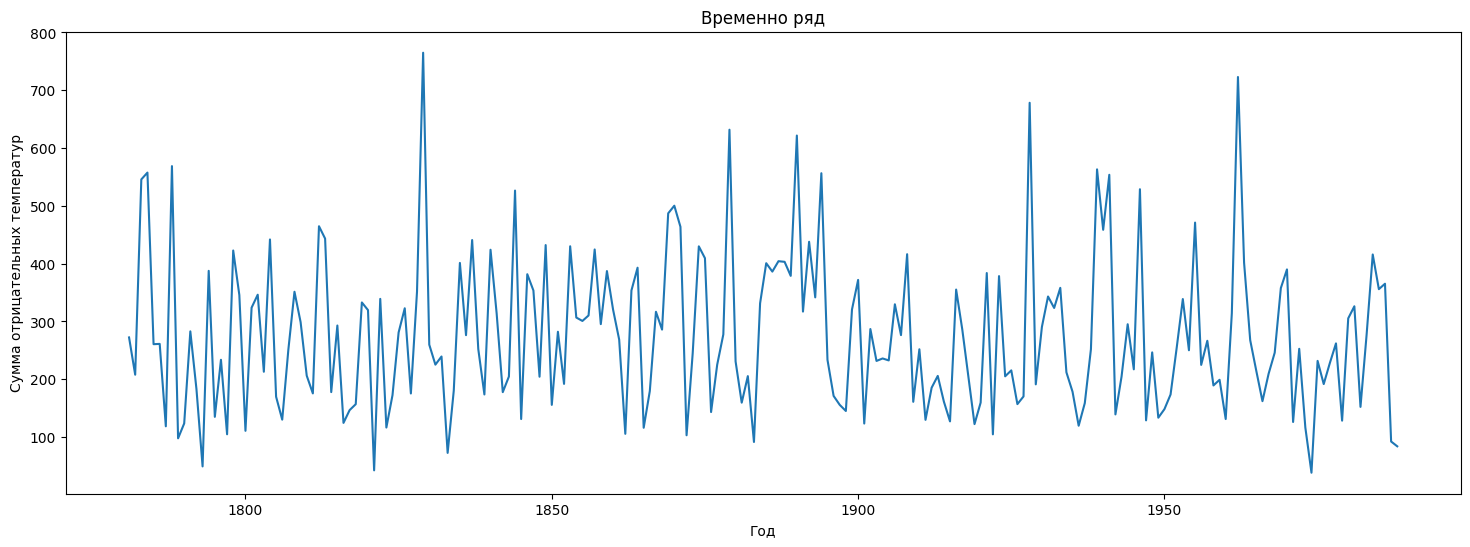

In [4]:
plt.figure(figsize=(18, 6))

plt.plot(df.t, df.x)
plt.title("Временно ряд")
plt.xlabel("Год")
plt.ylabel("Сумма отрицательных температур")

***

### Удаление тренда и сезонной компоненты

In [5]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера
def adFulersTest(ts: list, alpha=0.05):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', 'Lags Used', 'Number of observations used'])

    for key, val in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = val

    print(dfoutput)

    if dfoutput['p-value'] < alpha:
        print(f"Значение p меньше {alpha*100.0} %. Ряд стационарный")
    else:
        print(f"Значение p меньше {alpha*100.0} %. Ряд не стационарный\n")



adFulersTest(df.x)

Test Statistics               -1.312193e+01
p-value                        1.556814e-24
Lags Used                      0.000000e+00
Number of observations used    2.070000e+02
Critical value (1%)           -3.462342e+00
Critical value (5%)           -2.875606e+00
Critical value (10%)          -2.574267e+00
dtype: float64
Значение p меньше 5.0 %. Ряд стационарный


<i style="color: green">Этот ряд итак стационарный. Посмотрим что даст декомпозиция временного ряда</i>

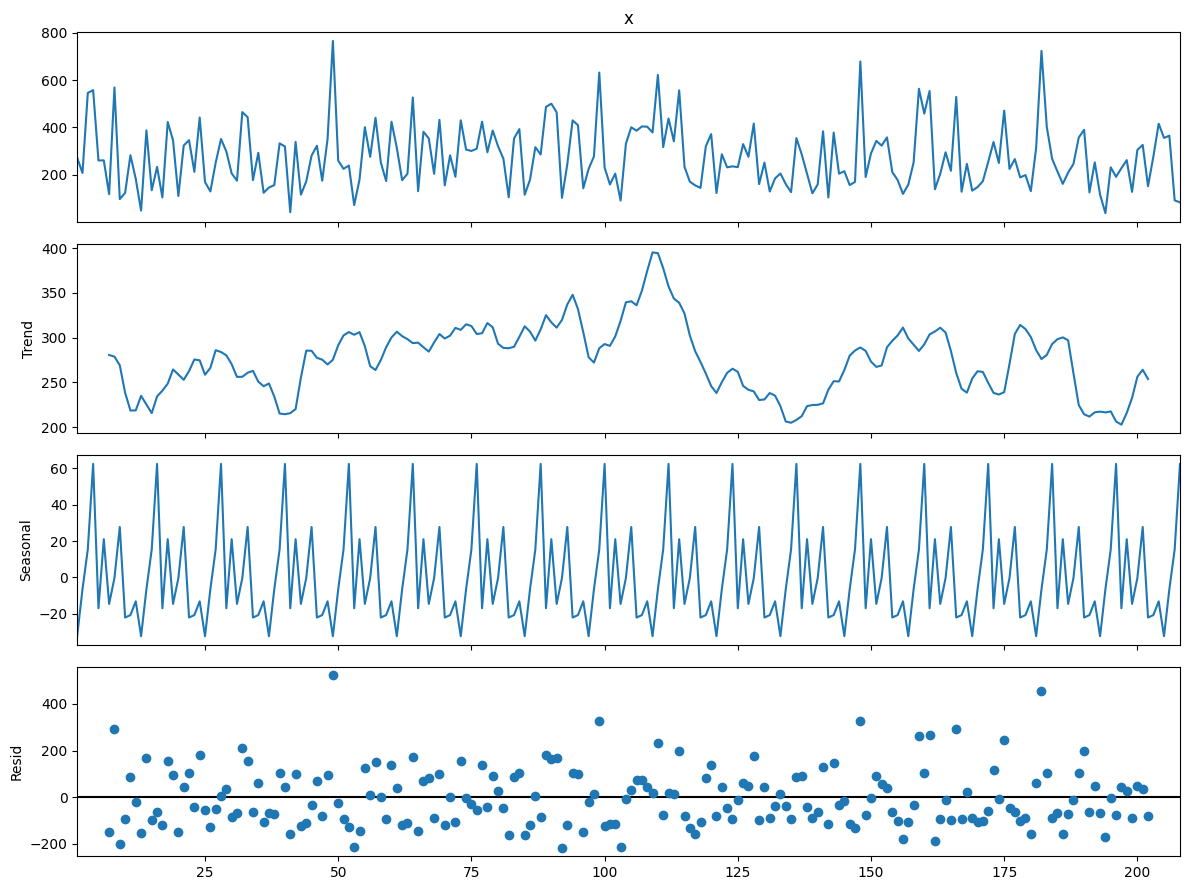

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df.x, period=12)

plt.rcParams['figure.figsize'] = 12, 9
decompose.plot()
plt.show()

<i style="color: green">Тренд не наблюдается</i>

Text(0.5, 1.0, 'Дифференцированный ряд со смещением 12')

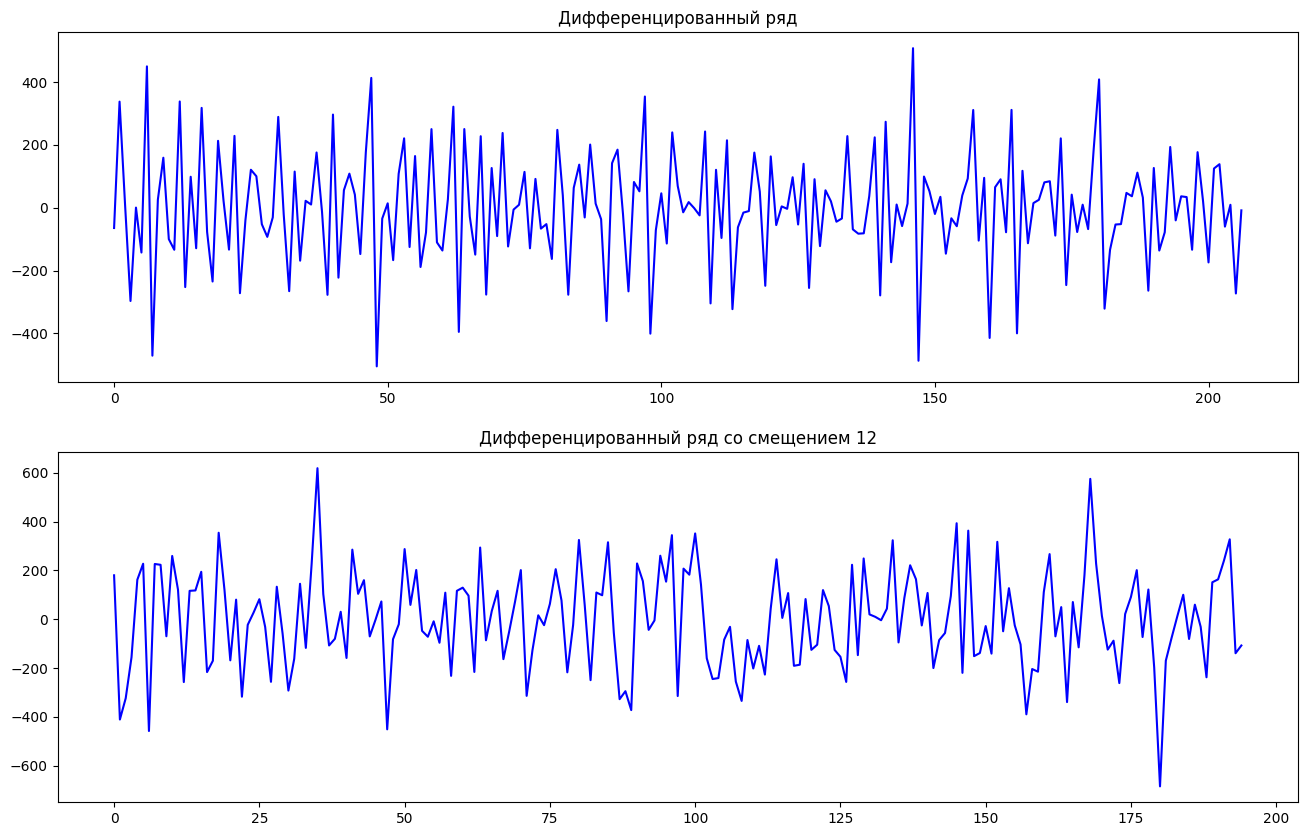

In [7]:
nottrend = []

s = 12
notseason = []

# Тренда не обнаружено, но давайте попробуем продиффиринцировать
for i in range(1, len(df.x)):
    nottrend.append(df.x.iloc[i] - df.x.iloc[i-1])

for i in range(s + 1, len(df.x)):
   notseason.append(df.x.iloc[i] - df.x.iloc[i-s])

plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.plot(nottrend, color='blue')
plt.title("Дифференцированный ряд")

plt.subplot(2, 1, 2)
plt.plot(notseason, color='blue')
plt.title("Дифференцированный ряд со смещением 12")

In [8]:
print("Температура (1 дифферинцирование)")
adFulersTest(nottrend)
print("\n\nТемпература (дифферинцирование со смещением 12)")
adFulersTest(notseason)

Температура (1 дифферинцирование)
Test Statistics               -7.461548e+00
p-value                        5.337534e-11
Lags Used                      1.400000e+01
Number of observations used    1.920000e+02
Critical value (1%)           -3.464875e+00
Critical value (5%)           -2.876714e+00
Critical value (10%)          -2.574859e+00
dtype: float64
Значение p меньше 5.0 %. Ряд стационарный


Температура (дифферинцирование со смещением 12)
Test Statistics               -7.868136e+00
p-value                        5.069427e-12
Lags Used                      1.100000e+01
Number of observations used    1.830000e+02
Critical value (1%)           -3.466598e+00
Critical value (5%)           -2.877467e+00
Critical value (10%)          -2.575260e+00
dtype: float64
Значение p меньше 5.0 %. Ряд стационарный


В данном случае диффиринцирование уже стационарного ряда только ухудшило показатели, хотя ряд по-прежнем стационарный

***

### Преобразование Бокса-Кокса

In [9]:
from scipy.stats import boxcox 

Best lambda: 0.3335382865354031


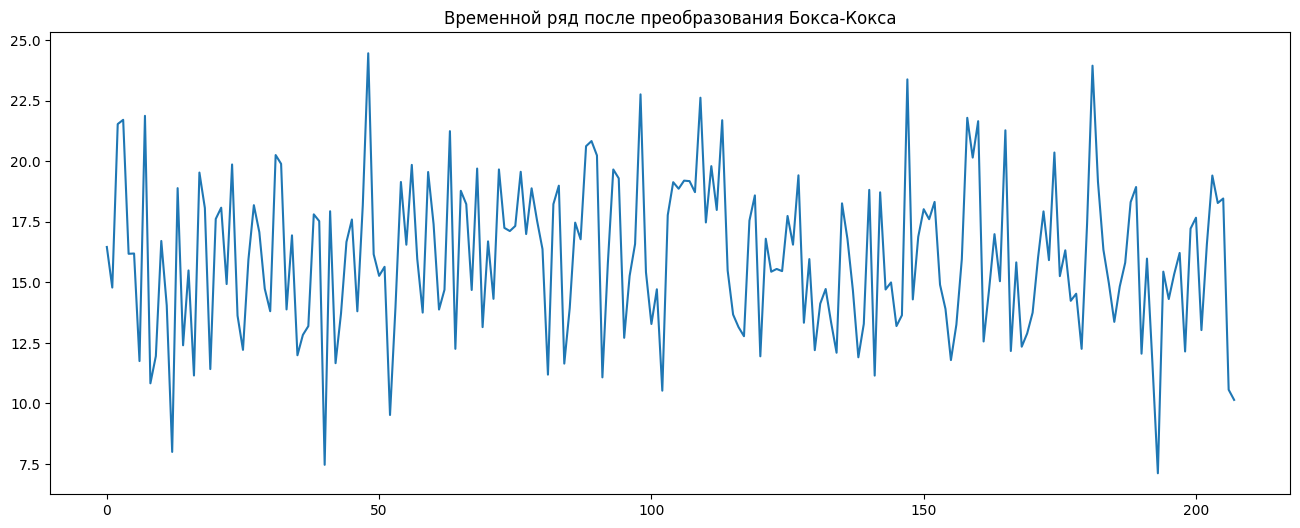

In [10]:
transformed_data, best_lambda = boxcox(df.x) 

plt.figure(figsize=(16, 6))
plt.plot(transformed_data)
plt.title("Временной ряд после преобразования Бокса-Кокса")

print(f"Best lambda: {best_lambda}")

Text(0.5, 1.0, 'Дифференцированный временной ряд после преобразования Бокса-Кокса')

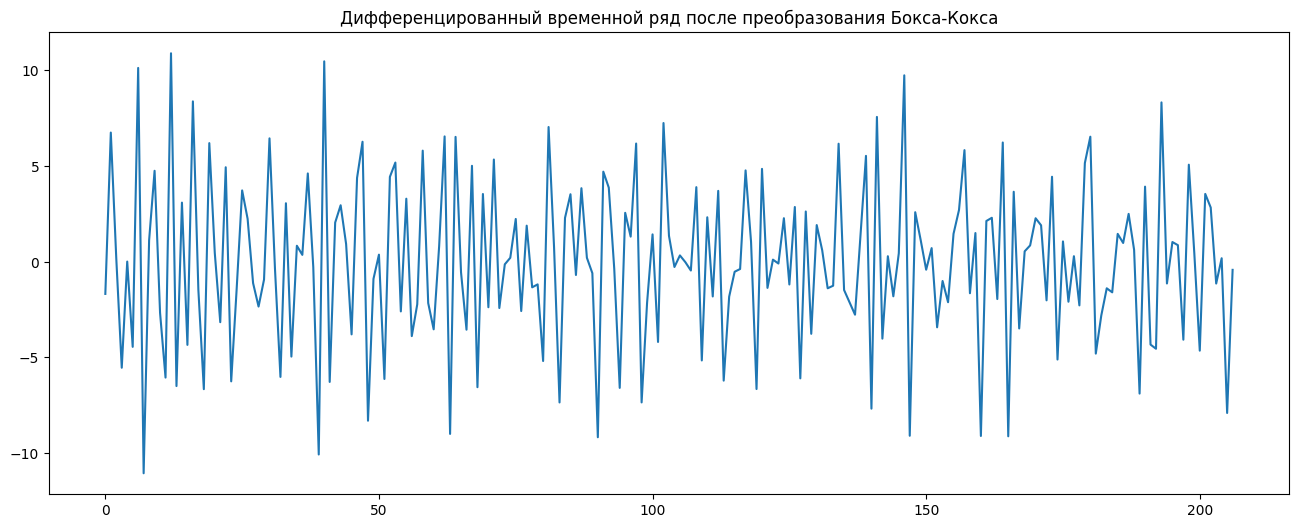

In [11]:
bc_nottrend = []

for i in range(1, len(transformed_data)):
   bc_nottrend.append(transformed_data[i] - transformed_data[i-1])

plt.figure(figsize=(16, 6))
plt.plot(bc_nottrend)
plt.title("Дифференцированный временной ряд после преобразования Бокса-Кокса") 

In [12]:
print("временной ряд после преобразования Бокса-Кокса (1 дифферинцирование)")
adFulersTest(bc_nottrend)

временной ряд после преобразования Бокса-Кокса (1 дифферинцирование)
Test Statistics               -7.540956e+00
p-value                        3.379262e-11
Lags Used                      1.400000e+01
Number of observations used    1.920000e+02
Critical value (1%)           -3.464875e+00
Critical value (5%)           -2.876714e+00
Critical value (10%)          -2.574859e+00
dtype: float64
Значение p меньше 5.0 %. Ряд стационарный


***

### Авторегрессионная модель

In [13]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [14]:
ardf = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv')
ardf['t'] = ardf.index.values
ardf['x'] = ardf.x.astype("float")

ardf.drop(ardf.columns[0], axis=1, inplace=True)

ardf.head()

,x,t
0,272.3,0
1,207.8,1
2,545.7,2
3,557.5,3
4,260.6,4


In [15]:
print(f"Std = {np.std(ardf.x)}\nMean = {np.mean(ardf.x)}")

Std = 134.24590557911225
Mean = 276.05288461538464


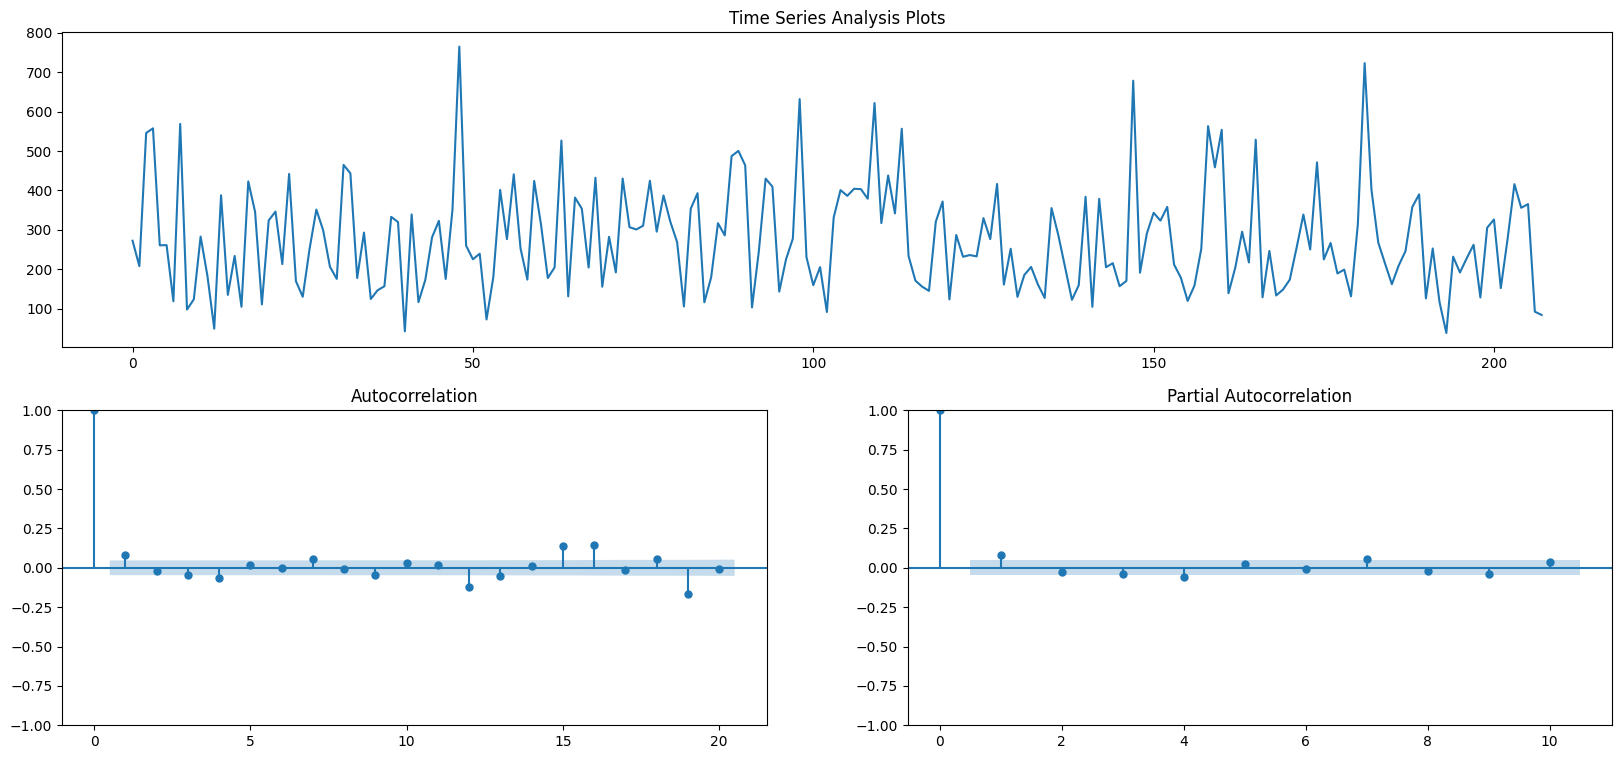

In [16]:
fig = plt.figure(figsize=(20, 9))

layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ardf.x.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ardf.x, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ardf.x, lags=10, ax=pacf_ax, alpha=0.5)

plt.show()

In [17]:
ln = len(ardf)

train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

train_df = ardf[ardf.t <= train_cutoff]
validate_df = ardf[(ardf.t > train_cutoff) & (ardf.t <= validate_cutoff)]
forecast_df = ardf[ardf.t > validate_cutoff]

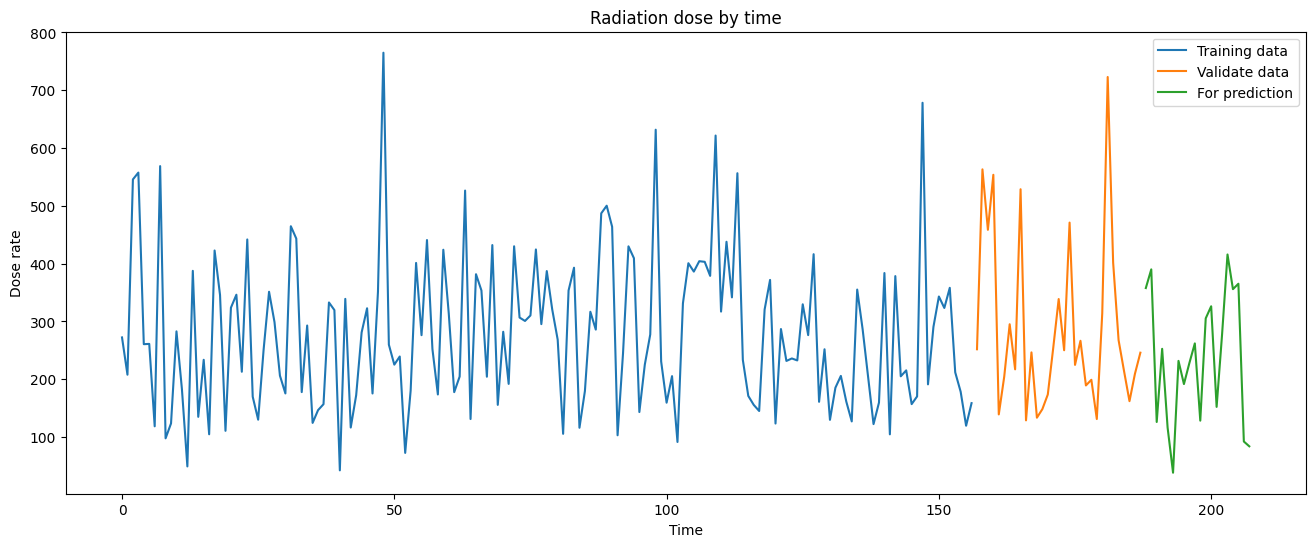

In [18]:
plt.figure(figsize=(16, 6))

plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')

plt.legend()
plt.title('Radiation dose by time')
plt.ylabel('Dose rate')
plt.xlabel('Time')

plt.show()

In [81]:
mod = AutoReg(ardf.x, 100, old_names=False)

res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  208
Model:                   AutoReg(100)   Log Likelihood                -548.064
Method:               Conditional MLE   S.D. of innovations             38.696
Date:                Sun, 10 Mar 2024   AIC                           1300.127
Time:                        20:41:42   BIC                           1573.705
Sample:                           100   HQIC                          1411.053
                                  208                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3758.2705    470.764      7.983      0.000    2835.590    4680.951
x.L1           0.2586      0.098      2.649      0.008       0.067       0.450
x.L2          -0.0436      0.091     -0.480      0.6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


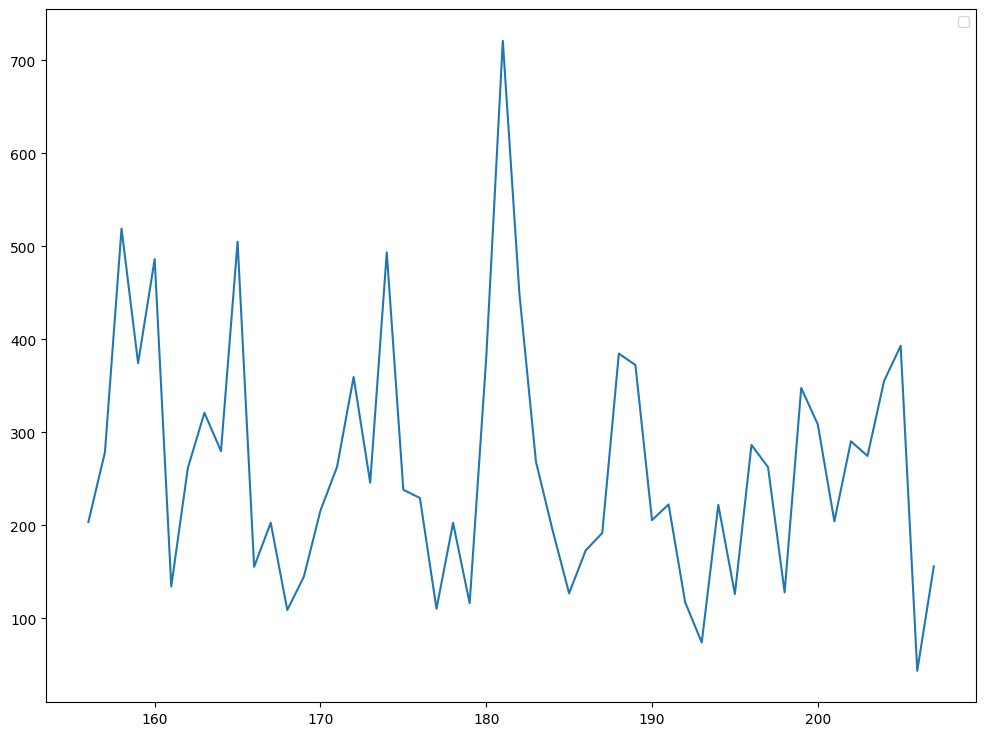

In [82]:
fig = res.plot_predict(train_cutoff)

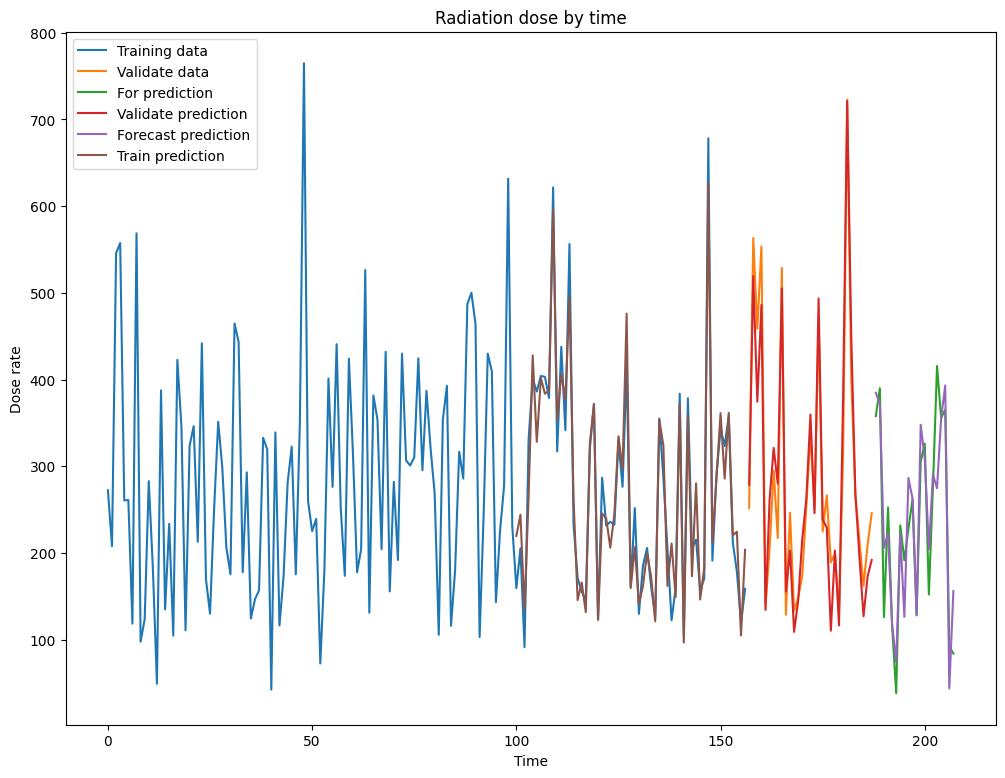

In [83]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff + 1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(ardf.t) - 1]), dynamic=False)

plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Radiation dose by time')
plt.ylabel('Dose rate')
plt.xlabel('Time')
plt.show()

Только при лаге 100 удалось получить более менее приемлимый результат

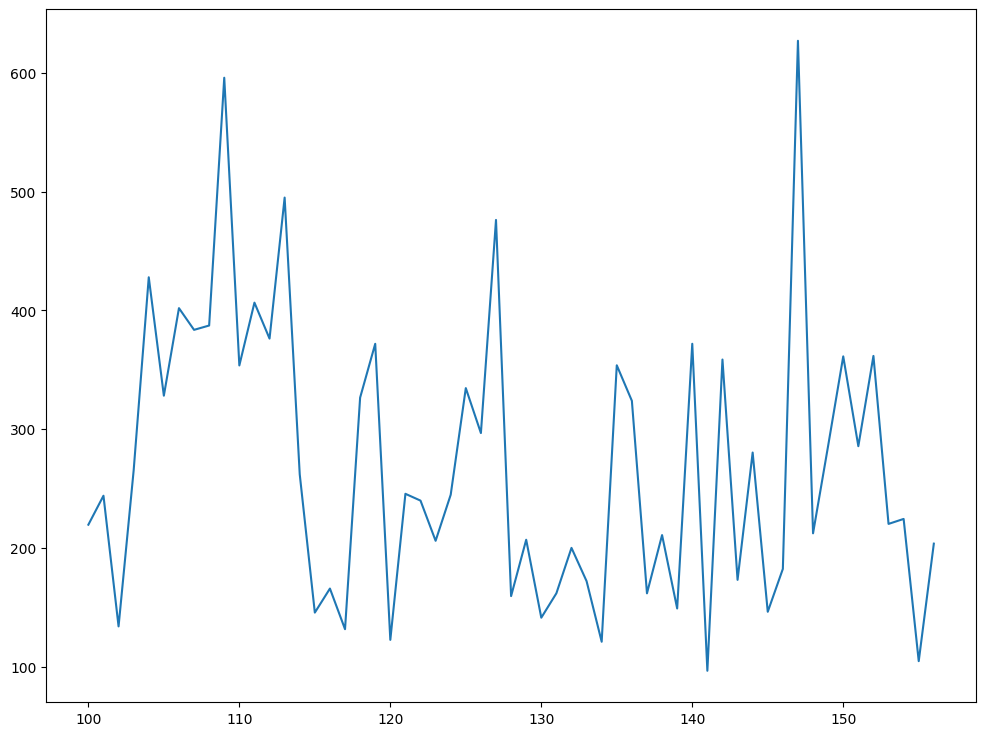

In [84]:
plt.plot(pred)

***

### Метрики

In [85]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [86]:
def symmetric_mean_absolute_percentage_error(y, y_pred):
    return 100 / len(y) * np.sum(2 * np.abs(y_pred - y) / (np.abs(y) + np.abs(y_pred)))

print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
print("SMAPE: ", symmetric_mean_absolute_percentage_error(forecast_df.x, f_pred), "%")

RMSE: 50.32105517435067
MAPE: 0.2427473169572997
MAE: 37.08132356699376
R2:  0.795383895593937
SMAPE:  21.93026308874318 %


Метрика R2 близка к 80 %, что довольно не плохо. Но нужно больше данных